# Kuvantunnistus omista kuvista
Tunnistetaan kuvia aterimista

In [1]:
# Importit
from keras.utils import to_categorical, image_dataset_from_directory
import pandas as pd
from keras import layers
from keras import models
from keras import callbacks
from keras import optimizers
from keras import regularizers
from keras.preprocessing import image
import os
import shutil
import random

#### Aluksi rajataan kuvat omiin kansioihinsa

In [2]:
import os
import shutil
import random

# Define paths
input_folder = 'OriginalPhotos'  # Source folder containing images
output_folder = 'DatasetSplit'  # Destination folder for train/val/test split

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Delete existing output folder if it exists
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# Ensure output folders exist
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_folder, split), exist_ok=True)

# Function to copy files while maintaining folder structure
def split_images(input_folder, output_folder, train_ratio, val_ratio, test_ratio):
    for root, dirs, files in os.walk(input_folder):
        if not files:  # Skip directories without files
            continue

        # Get relative path to preserve folder structure
        relative_path = os.path.relpath(root, input_folder)

        # Create corresponding subfolders in train, val, and test
        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join(output_folder, split, relative_path), exist_ok=True)

        # Shuffle files to randomize the split
        random.shuffle(files)

        # Calculate split indices
        total_files = len(files)
        train_end = int(total_files * train_ratio)
        val_end = train_end + int(total_files * val_ratio)

        # Split files into train, val, and test
        train_files = files[:train_end]
        val_files = files[train_end:val_end]
        test_files = files[val_end:]

        # Adjust for rounding issues to ensure val and test are equal
        while len(val_files) > len(test_files):
            test_files.append(val_files.pop())
        while len(test_files) > len(val_files):
            val_files.append(test_files.pop())

        # Copy files to respective folders
        for file in train_files:
            shutil.copy(os.path.join(root, file), os.path.join(output_folder, 'train', relative_path, file))
        for file in val_files:
            shutil.copy(os.path.join(root, file), os.path.join(output_folder, 'val', relative_path, file))
        for file in test_files:
            shutil.copy(os.path.join(root, file), os.path.join(output_folder, 'test', relative_path, file))

# Call the function
split_images(input_folder, output_folder, train_ratio, val_ratio, test_ratio)

print(f"Images have been split into train, validation, and test folders in '{output_folder}'")

Images have been split into train, validation, and test folders in 'DatasetSplit'


#### Tuodaan ja valmistellaan kuvat
- Augment data
- Luokitellaan kuvat
- Laitetaan kuvat datasettiin

In [3]:
imgSize = 224
imgPath = 'OriginalPhotos'
batchSize = 8

# Kopioi kuvat testi, train ja val kansioihin
# Testiin menee 20% kuvista, ja 80% menee train kansioon
# Jaetaan data 80/20 train/val


# Haetaan kuvat kansiosta ja luodaan DataFrame
train_dataset = image_dataset_from_directory(
    directory='DatasetSplit/train',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize, imgSize),
    batch_size=batchSize,
    color_mode="rgb",
    shuffle=True,
    seed=42,
)

val_dataset = image_dataset_from_directory(
    directory='DatasetSplit/val',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize, imgSize),
    batch_size=batchSize,
    color_mode="rgb",
    shuffle=True,
    seed=42,
)

test_dataset = image_dataset_from_directory(
    directory='DatasetSplit/test',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize, imgSize),
    batch_size=batchSize,
    color_mode="rgb",
    shuffle=True,
    seed=42
)

# TODO: Testi dataset (esim. erikseen kansio, jossa on testikuvat, jotka ei ole muiden kuvien seassa)
classNames = train_dataset.class_names
print('Class names: ', classNames)
classesAmount = len(train_dataset.class_names)

# Rescaling layer
rescale = layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (rescale(x), y))
val_dataset = val_dataset.map(lambda x, y: (rescale(x), y))

Found 31 files belonging to 3 classes.
Found 9 files belonging to 3 classes.
Found 7 files belonging to 3 classes.
Class names:  ['Haarukat', 'Lusikat', 'Veitset']


#### Malli 1: Oman CNN mallin koulutus ja testaus:

In [4]:
l2Reg = regularizers.l2(0.01)

# Data augmentation kuville
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.2),
])

# ----------- Havainnoissa jotain mätää, tää korjaa sen --------------
# Fix the batch dimension issue by unbatching and then rebatching
train_dataset = train_dataset.unbatch()
val_dataset = val_dataset.unbatch()

# Correctly rebatch the datasets
train_dataset = train_dataset.batch(batchSize)
val_dataset = val_dataset.batch(batchSize)
# -------------------------------------------------------------------

# Mallin kerrokset
model = models.Sequential([
    layers.Input(shape=(imgSize, imgSize, 3)),

    data_augmentation,

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu', kernel_regularizer=l2Reg),
    layers.Dropout(0.4),

    layers.Dense(classesAmount, activation='softmax')  # Output layer
])


early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=15,
    restore_best_weights=True
)

seOptimizer = optimizers.Adam(learning_rate=0.0005)

model.compile(
    optimizer=seOptimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Koulutetaan malli
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    verbose=1,
    callbacks=[early_stopping]
)

print("Koulutus valmis!")
print("Accuracy: ", history.history['accuracy'][-1])
print("Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Loss: ", history.history['loss'][-1])
print("Validation Loss: ", history.history['val_loss'][-1])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,243 (42.61 MB)

 Trainable params: 11,169,795 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/150
      4/Unknown 2s 138ms/step - accuracy: 0.3752 - loss: 13.1861

c:\Users\Administrator\VSCode projects\Neuroverkot\.conda\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.3711 - loss: 14.3032 - val_accuracy: 0.3333 - val_loss: 5.6879
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.6622 - loss: 11.5723 - val_accuracy: 0.3333 - val_loss: 5.4436
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.3544 - loss: 21.0691 - val_accuracy: 0.3333 - val_loss: 6.0279
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.6539 - loss: 17.8501 - val_accuracy: 0.3333 - val_loss: 8.8058
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.5606 - loss: 20.0632 - val_accuracy: 0.3333 - val_loss: 8.4488
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.4348 - loss: 20.2425 - val_accuracy: 0.3333 - val_loss: 7.3680
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.4598 - loss: 13.6294 - val_accuracy: 0.2222 - val_loss: 7.2023
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.3727 - loss: 21.7040 - val_accuracy: 0.3333 - val_l

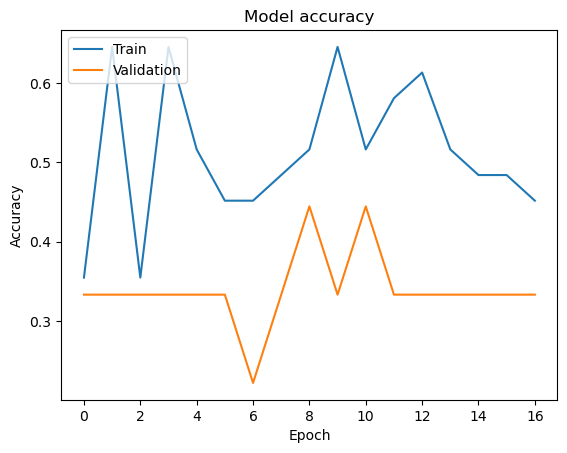

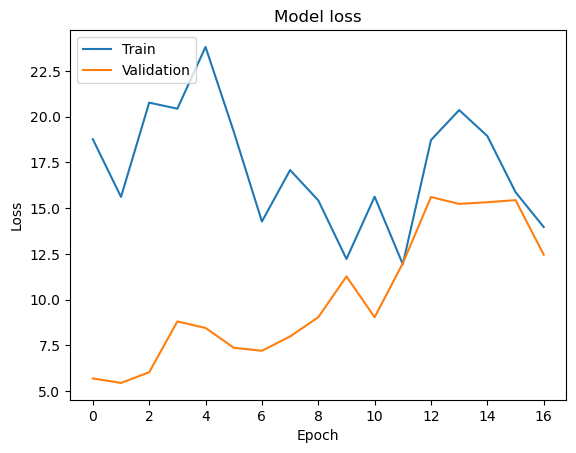

In [5]:
# Näytetään mallin treenihistoria
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Malli 2: Esikoulutettu malli

In [6]:
from keras.applications import VGG16

# Set the image size to match VGG16 input requirements
imgSize_vgg = 224
batchSize_vgg = 8
l2Reg = regularizers.l2(0.01)

# Annetaan VGG16 mallille samat datasetit, kuin edelliselle mallille
train_dataset_vgg = image_dataset_from_directory(
    directory='DatasetSplit/train',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize_vgg, imgSize_vgg),
    batch_size=batchSize_vgg,
    color_mode="rgb",
    shuffle=True,
    seed=42,
)

val_dataset_vgg = image_dataset_from_directory(
    directory='DatasetSplit/val',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize_vgg, imgSize_vgg),
    batch_size=batchSize_vgg,
    color_mode="rgb",
    shuffle=True,
    seed=42,
)

test_dataset_vgg = image_dataset_from_directory(
    directory='DatasetSplit/test',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize_vgg, imgSize_vgg),
    batch_size=batchSize_vgg,
    color_mode="rgb",
    shuffle=True,
    seed=42,
)

# Rescaling layer
rescale = layers.Rescaling(1./255)

# Taas skaalataan kuvat, niinkuin aikaisemmin
train_dataset_vgg = train_dataset_vgg.map(lambda x, y: (rescale(x), y))
val_dataset_vgg = val_dataset_vgg.map(lambda x, y: (rescale(x), y))
test_dataset_vgg = test_dataset_vgg.map(lambda x, y: (rescale(x), y))

# Load pre-trained VGG16 without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(imgSize_vgg, imgSize_vgg, 3))

# Freeze the convolutional base to use it as a feature extractor
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
vgg_model = models.Sequential([
    base_model, # Aiemmin otettu VGG16 malli
    # VGG mallin jälkeen lisätään omat kerrokset:
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2Reg),
    layers.Dropout(0.5),
    layers.Dense(classesAmount, activation='softmax')
])

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=15,
    restore_best_weights=True
)

seOptimizer = optimizers.Adam(learning_rate=0.0005)

vgg_model.compile(
    optimizer=seOptimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg_model.summary()

vgg_history = vgg_model.fit(
    train_dataset_vgg,
    validation_data=val_dataset_vgg,
    epochs=150,
    verbose=1,
    callbacks=[early_stopping]
)

print("Training complete!")
print("Accuracy: ", vgg_history.history['accuracy'][-1])
print("Validation Accuracy: ", vgg_history.history['val_accuracy'][-1])
print("Loss: ", vgg_history.history['loss'][-1])
print("Validation Loss: ", vgg_history.history['val_loss'][-1])

Found 31 files belonging to 3 classes.
Found 9 files belonging to 3 classes.
Found 7 files belonging to 3 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.3578 - loss: 6.9635 - val_accuracy: 0.4444 - val_loss: 5.4848
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - accuracy: 0.5948 - loss: 5.2130 - val_accuracy: 0.4444 - val_loss: 4.2516
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.7005 - loss: 3.6116 - val_accuracy: 0.3333 - val_loss: 4.1570
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - accuracy: 0.7801 - loss: 3.0802 - val_accuracy: 0.4444 - val_loss: 3.8064
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.7472 - loss: 2.7889 - val_accuracy: 0.4444 - val_loss: 3.4408
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - accuracy: 0.8438 - loss: 2.4735 - val_accuracy: 0.5556 - val_loss: 3.1000
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step - accuracy: 0.9663 - loss: 1.8886 - val_accuracy: 0.4444 - val_loss: 2.6580
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.9200 - loss: 1.8249 - val_accuracy: 0.4444 - v

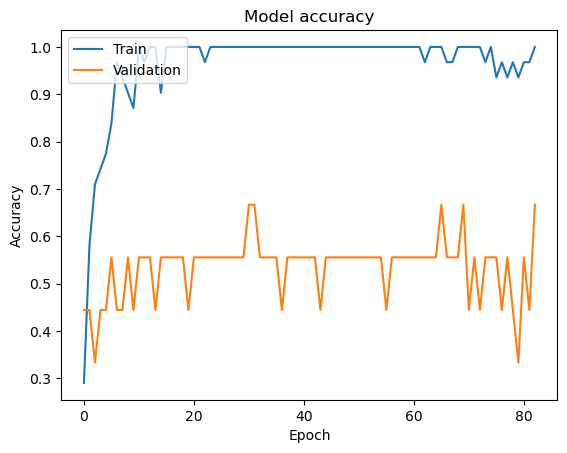

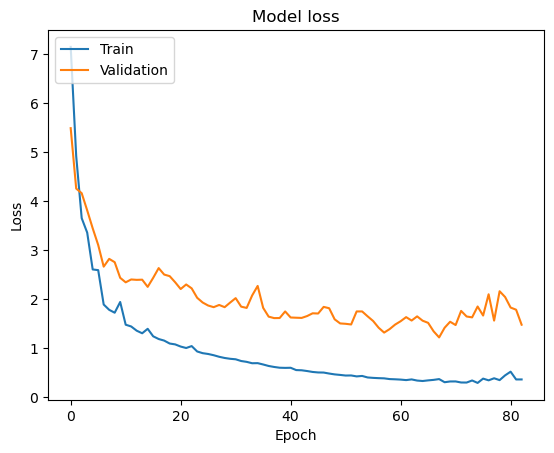

In [7]:
# Näytetään mallin treenihistoria
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Plot training & validation accuracy values
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Vaihe 3: RAPORTTI ja Analysointi: